# Knowledge Graph 기반 영화 임베딩 생성

영화-엔티티(배우, 감독, 장르 등) Knowledge Graph를 구축하고 Heterogeneous GNN으로 영화 임베딩을 학습합니다.

```
CARTE (독립 graphlet)                    Knowledge Graph (공유 노드)
                                         
영화A    영화B                              [영화A]───[Peter Jackson]───[영화B]
 │        │                                    │            │            │
[PJ]    [PJ]  ← 별개 노드, 같은 벡터         [Fantasy]    [NZ]      [Fantasy]
                                               │                        │
                                            [영화C]──────────────────────┘
```

In [1]:
import sys
sys.path.insert(0, "/Users/jisoo/projects/thesis/carte_test")

from config import PROCESSED

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
from huggingface_hub import hf_hub_download
from tqdm.auto import tqdm
import fasttext
import matplotlib.pyplot as plt

print(f"PyTorch: {torch.__version__}")

/Users/jisoo/projects/thesis/carte_test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.9.1


## 1. 데이터 로드

In [3]:
# 영화 카탈로그 로드
catalog = pd.read_parquet(PROCESSED.MOVIE_CATALOG_PARQUET)
ratings = pd.read_parquet(PROCESSED.RATINGS_PARQUET)

# ratings에 있는 영화만 필터링
movie_ids_in_ratings = ratings['movieId'].unique()
catalog_filtered = catalog[catalog['movieId'].isin(movie_ids_in_ratings)].reset_index(drop=True)

print(f"영화 수: {len(catalog_filtered):,}")
catalog_filtered.head()

영화 수: 53,630


,movieId,tmdbId,release_year,original_title,tagline,overview,produced_by_company_1,produced_by_company_2,produced_in_country_1,produced_in_country_2,spoken_language_1,spoken_language_2,actor_1,actor_2,actor_3,director_1,writer_1,genre_1,genre_2,genre_3
0,2858,14,1999,American Beauty,... look closer,"Lester Burnham, a depressed suburban father in...",DreamWorks Pictures,Jinks/Cohen Company,United States of America,None,English,None,Kevin Spacey,Annette Bening,Thora Birch,Sam Mendes,Alan Ball,Drama,None,None
1,923,15,1941,Citizen Kane,Some called him a hero...others called him a h...,Newspaper magnate Charles Foster Kane is taken...,Mercury Productions,RKO Radio Pictures,United States of America,None,English,None,Orson Welles,Joseph Cotten,Dorothy Comingore,Orson Welles,Orson Welles,Mystery,Drama,None
2,1266,33,1992,Unforgiven,Some legends will never be forgotten. Some wro...,"William Munny is a retired, once-ruthless kill...",Warner Bros. Pictures,Malpaso Productions,United States of America,None,English,None,Clint Eastwood,Gene Hackman,Morgan Freeman,Clint Eastwood,David Webb Peoples,Western,None,None
3,3910,16,2000,Dancer in the Dark,"In a world of shadows, she found the light of ...","Selma, a Czech immigrant on the verge of blind...",Zentropa Entertainments,DR,Denmark,Finland,English,None,Björk,Catherine Deneuve,David Morse,Lars von Trier,Lars von Trier,Drama,Crime,None
4,43589,17,2005,The Dark,One of the living for one of the dead.,"In an attempt to pull her family together, Adè...",Constantin Film,Impact Pictures,Germany,United Kingdom,Welsh,English,Maria Bello,Sean Bean,Abigail Stone,John Fawcett,Stephen Massicotte,Horror,Thriller,Mystery


## 2. Knowledge Graph 구축

In [4]:
# 엔티티 타입 정의
ENTITY_TYPES = {
    'actor': ['actor_1', 'actor_2', 'actor_3'],
    'director': ['director_1'],
    'writer': ['writer_1'],
    'genre': ['genre_1'],
    'company': ['produced_by_company_1'],
    'country': ['produced_in_country_1'],
    'language': ['spoken_language_1'],
}

def build_knowledge_graph(df: pd.DataFrame) -> tuple[HeteroData, dict, dict]:
    """영화 카탈로그에서 Heterogeneous Knowledge Graph 구축"""
    
    # 영화 ID 매핑
    movie_ids = df['movieId'].tolist()
    movie_to_idx = {mid: i for i, mid in enumerate(movie_ids)}
    
    # 엔티티별 유니크 값 수집 및 매핑
    entity_to_idx = {}
    for etype, cols in ENTITY_TYPES.items():
        unique_vals = set()
        for col in cols:
            if col in df.columns:
                unique_vals.update(df[col].dropna().unique())
        entity_to_idx[etype] = {v: i for i, v in enumerate(sorted(unique_vals))}
    
    # 엣지 구축
    edges = {etype: ([], []) for etype in ENTITY_TYPES}
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building edges"):
        movie_idx = movie_to_idx[row['movieId']]
        
        for etype, cols in ENTITY_TYPES.items():
            for col in cols:
                if col in df.columns and pd.notna(row[col]):
                    entity_val = row[col]
                    if entity_val in entity_to_idx[etype]:
                        entity_idx = entity_to_idx[etype][entity_val]
                        edges[etype][0].append(movie_idx)
                        edges[etype][1].append(entity_idx)
    
    # HeteroData 구축
    data = HeteroData()
    
    # 노드 수 설정
    data['movie'].num_nodes = len(movie_ids)
    for etype, mapping in entity_to_idx.items():
        data[etype].num_nodes = len(mapping)
    
    # 엣지 설정 (양방향)
    for etype, (src, dst) in edges.items():
        if len(src) > 0:
            edge_index = torch.tensor([src, dst], dtype=torch.long)
            data['movie', f'has_{etype}', etype].edge_index = edge_index
            data[etype, f'has_{etype}_rev', 'movie'].edge_index = edge_index.flip(0)
    
    return data, movie_to_idx, entity_to_idx

In [5]:
# KG 구축
kg_data, movie_to_idx, entity_to_idx = build_knowledge_graph(catalog_filtered)

print("\n[Knowledge Graph 통계]")
print(f"  영화 노드: {kg_data['movie'].num_nodes:,}")
for etype in entity_to_idx:
    print(f"  {etype} 노드: {kg_data[etype].num_nodes:,}")

total_edges = sum(kg_data[et].edge_index.size(1) for et in kg_data.edge_types)
print(f"\n  총 엣지 수: {total_edges:,}")
print(f"  엣지 타입: {len(kg_data.edge_types)}")

Building edges: 100%|██████████| 53630/53630 [00:01<00:00, 42719.72it/s]


[Knowledge Graph 통계]
  영화 노드: 53,630
  actor 노드: 62,550
  director 노드: 23,066
  writer 노드: 26,869
  genre 노드: 19
  company 노드: 19,420
  country 노드: 158
  language 노드: 136

  총 엣지 수: 923,378
  엣지 타입: 14


## 3. 노드 초기 임베딩 (fastText)

In [6]:
# fastText 모델 로드
print("fastText 모델 로딩...")
ft_path = hf_hub_download(repo_id="hi-paris/fastText", filename="cc.en.300.bin")
ft_model = fasttext.load_model(ft_path)
print("완료!")

fastText 모델 로딩...
완료!


In [7]:
def get_entity_embeddings(mapping: dict, ft_model, dim: int = 300) -> torch.Tensor:
    """엔티티 이름을 fastText로 임베딩"""
    idx_to_entity = {v: k for k, v in mapping.items()}
    n = len(mapping)
    emb = np.zeros((n, dim), dtype=np.float32)
    
    for idx in range(n):
        entity_name = idx_to_entity[idx]
        emb[idx] = ft_model.get_sentence_vector(str(entity_name))
    
    return torch.from_numpy(emb)

# 각 엔티티 타입별 초기 임베딩
print("엔티티 임베딩 생성...")
for etype, mapping in entity_to_idx.items():
    kg_data[etype].x = get_entity_embeddings(mapping, ft_model)
    print(f"  {etype}: {kg_data[etype].x.shape}")

# 영화 노드는 release_year로 초기화
movie_years = catalog_filtered['release_year'].fillna(2000).values.astype(np.float32)
movie_years_norm = (movie_years - movie_years.mean()) / (movie_years.std() + 1e-8)
kg_data['movie'].x = torch.from_numpy(
    np.tile(movie_years_norm[:, None], (1, 300)).astype(np.float32)
)
print(f"  movie: {kg_data['movie'].x.shape}")

엔티티 임베딩 생성...
  actor: torch.Size([62550, 300])
  director: torch.Size([23066, 300])
  writer: torch.Size([26869, 300])
  genre: torch.Size([19, 300])
  company: torch.Size([19420, 300])
  country: torch.Size([158, 300])
  language: torch.Size([136, 300])
  movie: torch.Size([53630, 300])


## 4. Heterogeneous GNN 모델

In [8]:
class HeteroGNN(nn.Module):
    """Heterogeneous Graph Neural Network using HeteroConv"""
    
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, edge_types: list, num_layers: int = 2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_dim if i == 0 else hidden_dim
            out_channels = out_dim if i == num_layers - 1 else hidden_dim
            
            conv_dict = {}
            for edge_type in edge_types:
                conv_dict[edge_type] = SAGEConv(in_channels, out_channels)
            self.convs.append(HeteroConv(conv_dict, aggr='mean'))
    
    def forward(self, x_dict, edge_index_dict):
        for i, conv in enumerate(self.convs):
            x_dict = conv(x_dict, edge_index_dict)
            if i < self.num_layers - 1:
                x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return x_dict

In [9]:
# 모델 생성
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

model = HeteroGNN(
    in_dim=300,
    hidden_dim=300,
    out_dim=300,
    edge_types=kg_data.edge_types,
    num_layers=2
).to(device)

print(f"\n모델 파라미터: {sum(p.numel() for p in model.parameters()):,}")

Device: cpu

모델 파라미터: 5,048,400


## 5. 학습 (Link Prediction)

In [10]:
def train_kg_embeddings(
    model: nn.Module,
    data: HeteroData,
    epochs: int = 100,
    lr: float = 0.01
) -> list:
    """Link prediction 기반 unsupervised 학습"""
    
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 학습할 엣지 타입 (movie -> entity)
    train_edge_types = [et for et in data.edge_types if et[0] == 'movie']
    
    losses = []
    pbar = tqdm(range(epochs), desc="Training")
    
    for epoch in pbar:
        optimizer.zero_grad()
        
        # Forward pass
        out_dict = model(data.x_dict, data.edge_index_dict)
        
        total_loss = 0
        for edge_type in train_edge_types:
            src_type, _, dst_type = edge_type
            edge_index = data[edge_type].edge_index
            
            if edge_index.size(1) == 0:
                continue
            
            # Positive samples
            src_emb = out_dict[src_type][edge_index[0]]
            dst_emb = out_dict[dst_type][edge_index[1]]
            pos_score = (src_emb * dst_emb).sum(dim=1)
            
            # Negative samples
            neg_dst_idx = torch.randint(0, data[dst_type].num_nodes, (edge_index.size(1),), device=device)
            neg_dst_emb = out_dict[dst_type][neg_dst_idx]
            neg_score = (src_emb * neg_dst_emb).sum(dim=1)
            
            # BPR Loss
            loss = -F.logsigmoid(pos_score - neg_score).mean()
            total_loss += loss
        
        total_loss.backward()
        optimizer.step()
        losses.append(total_loss.item())
        
        pbar.set_postfix({'loss': f'{total_loss.item():.2f}'})
    
    return losses

In [11]:
# 데이터를 device로 이동
kg_data = kg_data.to(device)

# 학습 실행
losses = train_kg_embeddings(model, kg_data, epochs=100, lr=0.01)

Training: 100%|██████████| 100/100 [04:52<00:00,  2.92s/it, loss=8.84]  


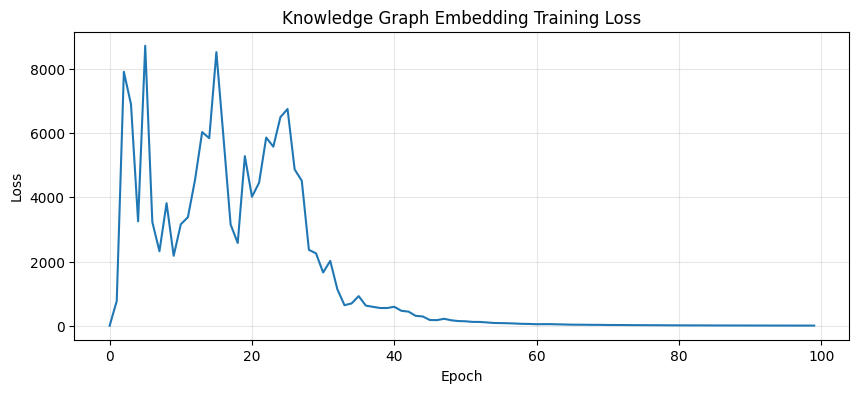

최종 Loss: 8.8378


In [12]:
# 학습 손실 시각화
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Knowledge Graph Embedding Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"최종 Loss: {losses[-1]:.4f}")

## 6. 임베딩 추출 및 저장

In [13]:
# 임베딩 추출
model.eval()
with torch.no_grad():
    out_dict = model(kg_data.x_dict, kg_data.edge_index_dict)
    movie_embeddings = out_dict['movie'].cpu().numpy()

print(f"영화 임베딩 shape: {movie_embeddings.shape}")

영화 임베딩 shape: (53630, 300)


In [14]:
# movieId 순서 복원
idx_to_movie = {v: k for k, v in movie_to_idx.items()}
movie_ids = np.array([idx_to_movie[i] for i in range(len(movie_to_idx))])

# Parquet으로 저장
EMBEDDINGS_DIR = PROCESSED.DIR / "ablation_embeddings"
EMBEDDINGS_DIR.mkdir(exist_ok=True)

df_emb = pd.DataFrame({
    'movieId': movie_ids,
    'embedding': [e.tolist() for e in movie_embeddings]
})

save_path = EMBEDDINGS_DIR / "emb_kg_gnn.parquet"
df_emb.to_parquet(save_path, index=False)

print(f"저장 완료: {save_path}")
print(f"  영화 수: {len(df_emb):,}")
print(f"  파일 크기: {save_path.stat().st_size / 1024 / 1024:.1f} MB")

저장 완료: /Users/jisoo/projects/thesis/carte_test/data/processed/ablation_embeddings/emb_kg_gnn.parquet
  영화 수: 53,630
  파일 크기: 95.0 MB


## 7. 임베딩 품질 확인

In [15]:
def compute_embedding_stats(emb: np.ndarray) -> dict:
    """임베딩 품질 통계"""
    norms = np.linalg.norm(emb, axis=1)
    valid = norms > 1e-10
    emb_norm = emb[valid] / norms[valid, None]
    
    # Anisotropy
    anisotropy = float(np.linalg.norm(emb_norm.mean(axis=0)))
    
    # Random pair cosine
    rng = np.random.default_rng(42)
    n = len(emb_norm)
    idx_a = rng.integers(0, n, size=50000)
    idx_b = rng.integers(0, n, size=50000)
    idx_b[idx_a == idx_b] = (idx_b[idx_a == idx_b] + 1) % n
    pair_cos = np.sum(emb_norm[idx_a] * emb_norm[idx_b], axis=1)
    
    return {
        'anisotropy': anisotropy,
        'pair_cos_mean': float(np.mean(pair_cos)),
        'pair_cos_std': float(np.std(pair_cos)),
        'pair_cos_p5': float(np.percentile(pair_cos, 5)),
        'pair_cos_p95': float(np.percentile(pair_cos, 95)),
    }

stats = compute_embedding_stats(movie_embeddings)

print("[KG GNN 임베딩 품질]")
print(f"  Anisotropy:      {stats['anisotropy']:.4f}")
print(f"  Pair Cos Mean:   {stats['pair_cos_mean']:.4f}")
print(f"  Pair Cos Std:    {stats['pair_cos_std']:.4f}")
print(f"  Pair Cos p5:     {stats['pair_cos_p5']:.4f}")
print(f"  Pair Cos p95:    {stats['pair_cos_p95']:.4f}")

[KG GNN 임베딩 품질]
  Anisotropy:      0.6991
  Pair Cos Mean:   0.4902
  Pair Cos Std:    0.2994
  Pair Cos p5:     0.0269
  Pair Cos p95:    0.9371


In [16]:
# CARTE와 비교
print("\n[CARTE 대비 비교]")
print("="*60)
print(f"{'지표':<20} {'CARTE full':>15} {'KG GNN':>15}")
print("-"*60)
print(f"{'Anisotropy':<20} {'0.9775':>15} {stats['anisotropy']:>15.4f}")
print(f"{'Pair Cos Mean':<20} {'0.9560':>15} {stats['pair_cos_mean']:>15.4f}")
print(f"{'Pair Cos p95':<20} {'0.9956':>15} {stats['pair_cos_p95']:>15.4f}")
print("="*60)
print("\n→ Anisotropy와 Pair Cos Mean이 낮을수록 좋음 (임베딩 공간 활용도 높음)")


[CARTE 대비 비교]
지표                        CARTE full          KG GNN
------------------------------------------------------------
Anisotropy                    0.9775          0.6991
Pair Cos Mean                 0.9560          0.4902
Pair Cos p95                  0.9956          0.9371

→ Anisotropy와 Pair Cos Mean이 낮을수록 좋음 (임베딩 공간 활용도 높음)
